In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()


import shapely
import shapely.vectorized

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import geopy
import geopy.distance
import geopandas

import cartopy.io.shapereader as shpreader


import pandas as pd

In [24]:
df = pd.read_csv('data/forGeoMap.csv')
#Split out North America from rest of Americas
df.loc[df['Alpha-3'].isin(['CAN', 'MEX','USA']), 'UN continental'] = 'North America'

print(df.shape)

df.head()

(12397, 68)


,Unnamed: 0,id,content,title,relevant,seen,random,2 - Adaptation,2 - Mitigation,2 - Other,...,word,country_predicted,country_conf,Alpha-3,UN continental,UN statistical,Annex I or II,Code,Region,Income group
0,1115.0,1790670.0,The contributions of small local non-governmen...,The Voices of Local NGOs in Climate Change Iss...,NaN,NaN,NaN,0.0,0.0,0.0,...,Nepal,NPL,0.945330,NPL,Asia,Southern Asia,Non-Annex I,NPL,South Asia,Lower middle income
1,1858.0,1987973.0,Climate actions are centered on either mitigat...,An assessment of potential synergies and trade...,NaN,NaN,NaN,0.0,0.0,0.0,...,Nepal,NPL,0.948191,NPL,Asia,Southern Asia,Non-Annex I,NPL,South Asia,Lower middle income
2,3207.0,4918397.0,Background Nepal's 2015 earthquake and its aft...,Differential vulnerability and resilience of e...,NaN,NaN,NaN,0.0,0.0,0.0,...,Nepal,NPL,0.951695,NPL,Asia,Southern Asia,Non-Annex I,NPL,South Asia,Lower middle income
3,5602.0,572578.0,BackgroundIn this paper we examine the role of...,The role of collective action in enhancing com...,NaN,NaN,NaN,0.0,0.0,0.0,...,Nepalgunj,NPL,0.893303,NPL,Asia,Southern Asia,Non-Annex I,NPL,South Asia,Lower middle income
4,7111.0,450978.0,Nepal is one of the 20 most disaster-prone cou...,Women's Empowerment in Building Disaster Resil...,NaN,NaN,NaN,0.0,0.0,0.0,...,Rautahat,NPL,0.930774,NPL,Asia,Southern Asia,Non-Annex I,NPL,South Asia,Lower middle income


In [33]:
df['country_code3'].value_counts().head(15)

USA    2172
AUS     666
GBR     480
CAN     440
CHN     414
IND     399
DEU     342
NLD     286
BRA     285
ZAF     208
PHL     183
ESP     179
FRA     176
IDN     170
VNM     160
Name: country_code3, dtype: int64

In [3]:

def new_haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1[:,None]

    dlat = lat2 - lat1[:,None]

    a = np.sin(dlat/2.0)**2 + np.cos(lat1[:,None]) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def density_grid(df, degrees = 0.5, distance = 200, countryColumn = "country_predicted", places = "fromMordecai"):
    
    if places == "fromMordecai":
        df_countries = df[df["feature_code"]=="PCLI"]
        df_places = df[df["feature_code"]!="PCLI"]
    elif places == False: #Countries only
        df_countries = df
        df_places = df

    distance = distance #Size of blobs

    latbins = np.linspace(-90,90, round(180/degrees))
    lonbins = np.linspace(-180,180, round(360/degrees))

    n = np.zeros((len(latbins),len(lonbins)))
    
    print(f"calculating density grid of size: {n.size}")

    for i,lat in enumerate(latbins):
        r = geopy.distance.distance(kilometers=distance)
        latp = geopy.Point((lat,135))
        # if the latitude is closer than distance to the north pole, then the northern bound should be 
        # the north pole, not distancekm north of the latitude (which will pass the pole and go south again)
        if geopy.distance.great_circle(latp,(90,135)).km < distance:
            r_nbound = 90   
        else:
            r_nbound = r.destination(point=latp,bearing=0).latitude
        # Same as above for the south pole
        if geopy.distance.great_circle(latp,(-90,135)).km < distance:
            r_sbound = -90   
        else:
            r_sbound = r.destination(point=latp,bearing=180).latitude
            
        if places != False:
            latbound_df = df_places[
                (df_places.lat>=r_sbound) &
                (df_places.lat<=r_nbound)        
            ]

            ds = new_haversine_np(latbound_df['lon'], latbound_df['lat'],lonbins,[lat]*len(lonbins))

            n[i,:] = np.where(ds<distance,1,0).sum(axis=0)
        
    print("Grid calculated")
    
    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    yv, xv = np.meshgrid(latbins, lonbins)

    for country in reader.records():
        incountry = shapely.vectorized.contains(country.geometry,xv,yv)
        idx = np.argwhere(incountry==True)
        cdf = df_countries[df_countries[countryColumn]==country.attributes["SU_A3"]]
        
        if places != False: #See how many "dots" are in the country, divide country-level mentions by this nr
            ndots = idx.size/2
            for point in idx:
                n[point[1],point[0]] += cdf.shape[0]/ndots
        else:
            for point in idx:
                n[point[1],point[0]] += cdf.shape[0]

    print("Countries added")
        
    return latbins, lonbins, n

latbins, lonbins, n = density_grid(df)

calculating density grid of size: 259200


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning

Grid calculated
Countries added


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


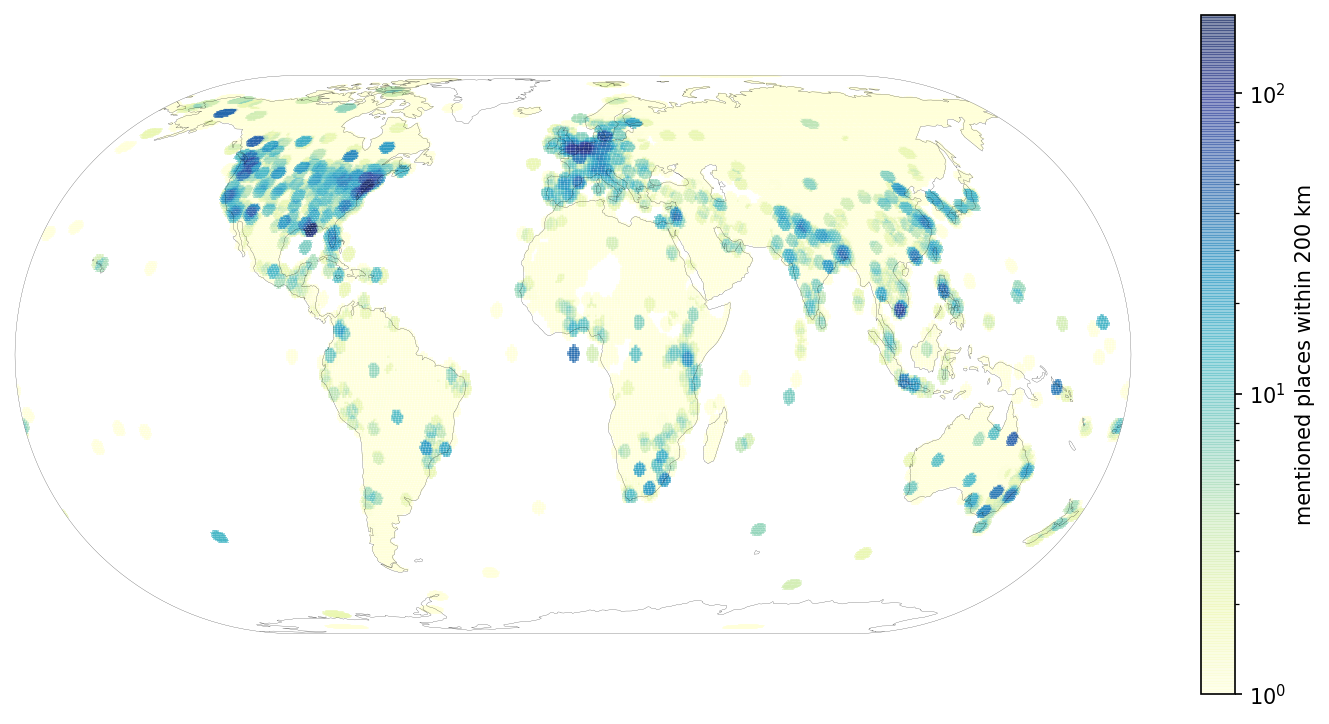

In [4]:
fig, ax = plt.subplots(dpi=150, figsize=(12,6))

#p = ccrs.Mollweide() #Choose projection
#p = ccrs.PlateCarree()
p = ccrs.EckertIV()

ax = plt.axes(projection=p)
ax.set_global()
ax.coastlines(lw=0.1)

vm = n[~np.isnan(n)].max()

n[n == 0] = np.nan

pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

ax.outline_patch.set_linewidth(0.1)

cbar = fig.colorbar(pcm)
cbar.set_label("mentioned places within 200 km")

fig.tight_layout()



### Finding regionally dominant topics

In [5]:
dts = pd.read_csv('data/DocTopicsID.csv', encoding='UTF-8')
dts.rename(columns={'id':'doc_id'}, inplace=True)#To avoid confusion with the topic ids
print(dts.shape)
dts.head()

(8599, 106)


,doc_id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105
0,627113.0,0.006773,0.009400,0.013150,0.001726,0.001901,0.018476,0.003203,0.010839,0.000664,...,0.010647,0.003359,0.003282,0.005095,0.002677,0.004748,0.000653,0.030619,0.011716,0.014370
1,3682515.0,0.010527,0.004135,0.005840,0.002209,0.003941,0.018598,0.000861,0.018114,0.006106,...,0.000417,0.000415,0.065895,0.008822,0.013801,0.003962,0.000712,0.015213,0.000602,0.016076
2,3951130.0,0.010204,0.004205,0.005951,0.008295,0.046054,0.014739,0.000803,0.010283,0.001384,...,0.005475,0.000641,0.003657,0.004603,0.005086,0.006768,0.001116,0.013086,0.000271,0.004331
3,3531413.0,0.029882,0.007683,0.007710,0.011978,0.009821,0.011879,0.016175,0.014663,0.000798,...,0.038245,0.001415,0.001430,0.013808,0.007009,0.004548,0.000782,0.121393,0.001362,0.010262
4,4918194.0,0.024396,0.002991,0.006632,0.005316,0.008324,0.016333,0.000866,0.007352,0.022635,...,0.000866,0.001627,0.010526,0.013156,0.004272,0.006475,0.000661,0.013983,0.001490,0.005013


In [6]:
#Create df with total score
dt_sum = pd.DataFrame(
    dts.sum(axis=0),
    columns = ['total_score']
).drop('doc_id').reset_index().rename(columns={'index':'topic_id'})
dt_sum['total_share'] = dt_sum['total_score'] / dt_sum ['total_score'].sum()
dt_sum.head()

,topic_id,total_score,total_share
0,V1,126.518064,0.014713
1,V2,74.188890,0.008628
2,V3,77.914162,0.009061
3,V4,77.690299,0.009035
4,V5,97.106952,0.011293


In [7]:
#Remove the geographical topics
GeoTopics = [2, 21, 29, 34, 62, 71, 104]
GeoTopics = [f"V{t}" for t in GeoTopics]

dt_sum = dt_sum[~dt_sum['topic_id'].isin(GeoTopics)]
dt_sum.shape

(98, 3)

In [8]:
topic_info = pd.read_excel('data/105_named.xlsx')
topic_info = topic_info.iloc[::4, :] #Keep every 4th row, as this table includes 4 types of keywords per topic
topic_info.rename(columns={'Topic name': 'title'}, inplace=True)
topic_info['id'] = [f"V{c}" for c in topic_info['Topic NR']]
topic_info.head()

,Topic NR,title,Short,Notes,Top keywords,id
0,1,Sustainable development,Sustainable,NaN,"Highest Prob: develop, sustain, climat_develo...",V1
4,2,Plays a role,Role,Junk,"Highest Prob: role, import, effort, play, pla...",V2
8,3,Precipitation variability,Precipitation,ENSO = El Nino Souther Oscilation,"Highest Prob: drought, rainfal, year, increas...",V3
12,4,Stakeholder involvement,Stakeholder,NaN,"Highest Prob: process, stakehold, tool, decis...",V4
16,5,Legislation,Legislation,NaN,"Highest Prob: new, law, legal, articl, regul,...",V5


In [9]:
continent_rep = []


def get_group_topics(name, group, dts, nlabs=5):
    gdt = dts[dts['doc_id'].isin(group.id)] #Select all documents for the group
    #gdt = pd.DataFrame(gdt.groupby('topic_id')['score'].aggregate("sum")).reset_index() #For each topic, get topic sum
    gdt = pd.DataFrame(gdt.set_index('doc_id').sum()
                      ).reset_index().rename(columns={'index': 'topic_id', 0: 'score'})
    #return(gdt)
    gdt['continent'] = name
    gdt['share'] = gdt['score'] / gdt['score'].sum()    
    
    gdt = gdt.merge(dt_sum)
    gdt['deviation'] = gdt['share'] / gdt['total_share']
    
    top_topics = gdt.sort_values('deviation').tail(nlabs).merge(topic_info,left_on="topic_id",right_on="id")
    bottom_topics = gdt.sort_values('deviation').head(nlabs).merge(topic_info,left_on="topic_id",right_on="id")    
    
    return {
        "name": name,
        "common_topics": [x.split(',')[0] for x in top_topics.title],
        "common_topics_scores": top_topics.deviation,
        "uncommon_topics": [x.split(',')[0] for x in bottom_topics.title],
        "uncommon_topics_scores": bottom_topics.deviation
    }


for name, group in df.groupby('UN continental'):
    if name != 'Antartica': #Don't have enough studies here for it to be meaningful
        continent_rep.append(get_group_topics(name, group, dts))
    
len(continent_rep)

6

In [10]:
country_conv = pd.read_csv("data/CountryMappingTable.csv")
country_conv.head()

,Country,Alpha-2,Alpha-3,Numeric code,Latitude (average),Longitude (average),UN continental,UN statistical,Population_2018,Population_2019,Annex I or II,SIDS,DFID priority,World Bank Income,World Bank Region,Income group
0,Afghanistan,AF,AFG,4,33.0000,65.0,Asia,Southern Asia,"37,171,921","38,041,754",Non-Annex I,,1,Low,South Asia,Low income
1,Albania,AL,ALB,8,41.0000,20.0,Europe,Southern Europe,"2,882,740","2,880,917",Non-Annex I,NaN,0,Upper-middle,Europe & Central Asia,Upper middle income
2,Algeria,DZ,DZA,12,28.0000,3.0,Africa,Northern Africa,"42,228,408","43,053,054",Non-Annex I,NaN,0,Upper-middle,Middle East & North Africa,Lower middle income
3,American Samoa,AS,ASM,16,-14.3333,-170.0,Oceania,Polynesia,"55,465","55,312",Non-Annex I,Pacific,0,Upper-middle,East Asia & Pacific,Upper middle income
4,Andorra,AD,AND,20,42.5000,1.6,Europe,Southern Europe,"77,006","77,142",Non-Annex I,NaN,0,High,Europe & Central Asia,High income


In [11]:
df = df.merge(country_conv,left_on="country_predicted",right_on="Alpha-3", suffixes=('', '_y'))

df.drop(df.filter(regex='_y$').columns, axis=1, inplace=True) #Avoid creating duplicate columns
df.head()

,Unnamed: 0,id,content,title,relevant,seen,random,2 - Adaptation,2 - Mitigation,2 - Other,...,Alpha-2,Numeric code,Latitude (average),Longitude (average),Population_2018,Population_2019,SIDS,DFID priority,World Bank Income,World Bank Region
0,1115.0,1790670.0,The contributions of small local non-governmen...,The Voices of Local NGOs in Climate Change Iss...,NaN,NaN,NaN,0.0,0.0,0.0,...,NP,524,28.0,84.0,"28,095,714","28,608,710",NaN,1,Low,South Asia
1,1858.0,1987973.0,Climate actions are centered on either mitigat...,An assessment of potential synergies and trade...,NaN,NaN,NaN,0.0,0.0,0.0,...,NP,524,28.0,84.0,"28,095,714","28,608,710",NaN,1,Low,South Asia
2,3207.0,4918397.0,Background Nepal's 2015 earthquake and its aft...,Differential vulnerability and resilience of e...,NaN,NaN,NaN,0.0,0.0,0.0,...,NP,524,28.0,84.0,"28,095,714","28,608,710",NaN,1,Low,South Asia
3,5602.0,572578.0,BackgroundIn this paper we examine the role of...,The role of collective action in enhancing com...,NaN,NaN,NaN,0.0,0.0,0.0,...,NP,524,28.0,84.0,"28,095,714","28,608,710",NaN,1,Low,South Asia
4,7111.0,450978.0,Nepal is one of the 20 most disaster-prone cou...,Women's Empowerment in Building Disaster Resil...,NaN,NaN,NaN,0.0,0.0,0.0,...,NP,524,28.0,84.0,"28,095,714","28,608,710",NaN,1,Low,South Asia


In [12]:
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')

country_shapes = geopandas.read_file(shpfilename).merge(country_conv,left_on="ADM0_A3",right_on="Alpha-3")
country_shapes.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,UN continental,UN statistical,Population_2018,Population_2019,Annex I or II,SIDS,DFID priority,World Bank Income,World Bank Region,Income group
0,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,1,Zimbabwe,...,Africa,Eastern Africa,"14,438,802","14,645,468",Non-Annex I,NaN,1,Lower-middle,Sub-Saharan Africa,Lower middle income
1,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,1,Zambia,...,Africa,Eastern Africa,"17,351,708","17,861,030",Non-Annex I,NaN,1,Lower-middle,Sub-Saharan Africa,Low income
2,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,1,Yemen,...,Asia,Western Asia,"28,498,683","29,161,922",Non-Annex I,NaN,1,Low,Middle East & North Africa,Low income
3,Admin-0 country,3,2,Vietnam,VNM,0,2,Sovereign country,1,Vietnam,...,Asia,South-eastern Asia,"95,545,962","96,462,106",Non-Annex I,NaN,0,Lower-middle,East Asia & Pacific,Lower middle income
4,Admin-0 country,5,3,Venezuela,VEN,0,2,Sovereign country,1,Venezuela,...,Americas,South America,"28,887,118","28,515,829",Non-Annex I,NaN,0,Upper-middle,Latin America & Caribbean,NaN


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


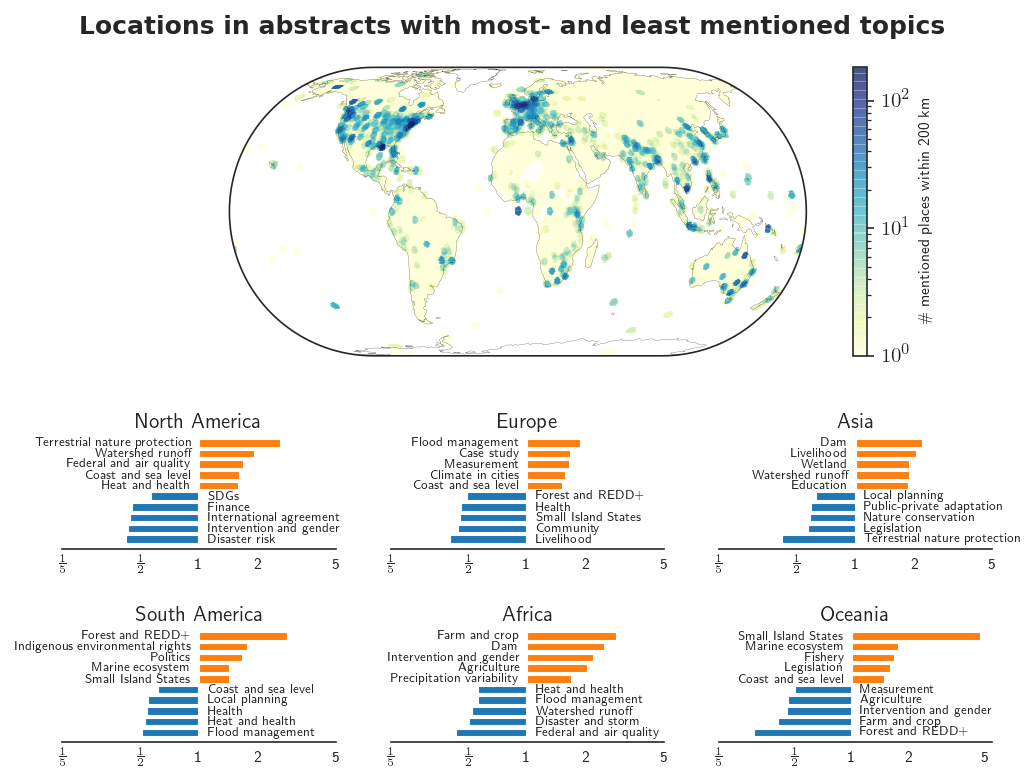

In [13]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)

sns.set_style("white", {'font.sans-serif':['OpenSans']})

fig = plt.figure(dpi=150,figsize=(8,5))

gs = gridspec.GridSpec(3, 3, #One row for map, two rows with 3 bars each
                       height_ratios=[1, .4, .4], 
                       bottom=.05, top=.95, wspace=.2, hspace=.45)

ax1 = plt.subplot(gs[0, :], projection = ccrs.EckertIV()) #Set projection here
ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform= ccrs.PlateCarree(), #Setting this to anything but PlateCarree seems to get an empty output
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)


cbar = fig.colorbar(pcm)
cbar.set_label("\# mentioned places within 200 km", size = 7)

pad = 0.1

xlab_positions = [.2,.5,1,2,5]
xlabels = [r"$\frac{1}{5}$",r"$\frac{1}{2}$",1,2,5]

ax_order = [4, 3, 2, 1, 0, 5]

continents = { #mapping from the name used in the table to whatever you want to use as title
    'Americas': 'South America', #these were not replaced above
    'North America': 'North America',
    'Asia': 'Asia',
    'Oceania': 'Oceania',
    'Africa': 'Africa',
    'Europe': 'Europe',
    #'Antartica': 'Antartica'
}


for i, cr in enumerate(continent_rep):
    order = ax_order[i]
    ax = plt.subplot(gs[1+order//3,order%3]) #First row or second row
    l = len(cr["common_topics_scores"])
    ax.set_title(continents[cr["name"]], size = 10, pad=3)
    ax.barh(range(l),np.log(cr["uncommon_topics_scores"]))
    ax.barh(range(l,l*2),np.log(cr["common_topics_scores"]))
    for j, lab in enumerate(cr["uncommon_topics"]):
        ax.text(0+pad,j,lab,ha="left", va="center", fontsize=6, usetex=True)
    for j, lab in enumerate(cr["common_topics"]):
        ax.text(0-pad,j+l, lab, ha="right", va="center", fontsize=6, usetex=True)
    sns.despine(ax=ax,top=True,left=True)
    ax.set_yticks([])
    ax.tick_params(length = 1)
    ax.set_xticks([np.log(lab) for lab in xlab_positions])
    #ax.set_xticks(xlab_positions)
    ax.set_xticklabels(xlabels, fontsize=7, usetex=True)
    #ax.set_yticklabels(cr["uncommon_topics"] + cr["common_topics"],fontsize=6)


continent_df = pd.DataFrame

plt.suptitle("Locations in abstracts with most- and least mentioned topics", 
             weight='bold', fontsize = 12,
             usetex=False,
            y=1.02)

#ax1.set_title("Geographic spread of research and relative importance of topics by continent", weight='bold', usetex=False)

fig.tight_layout()

plt.savefig(r"Out/topics_continent.png", bbox_inches='tight')

In [14]:
income = []
nlabs = 5

for name, group in df.groupby('Income group'):
    income.append(get_group_topics(name, group, dts))

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


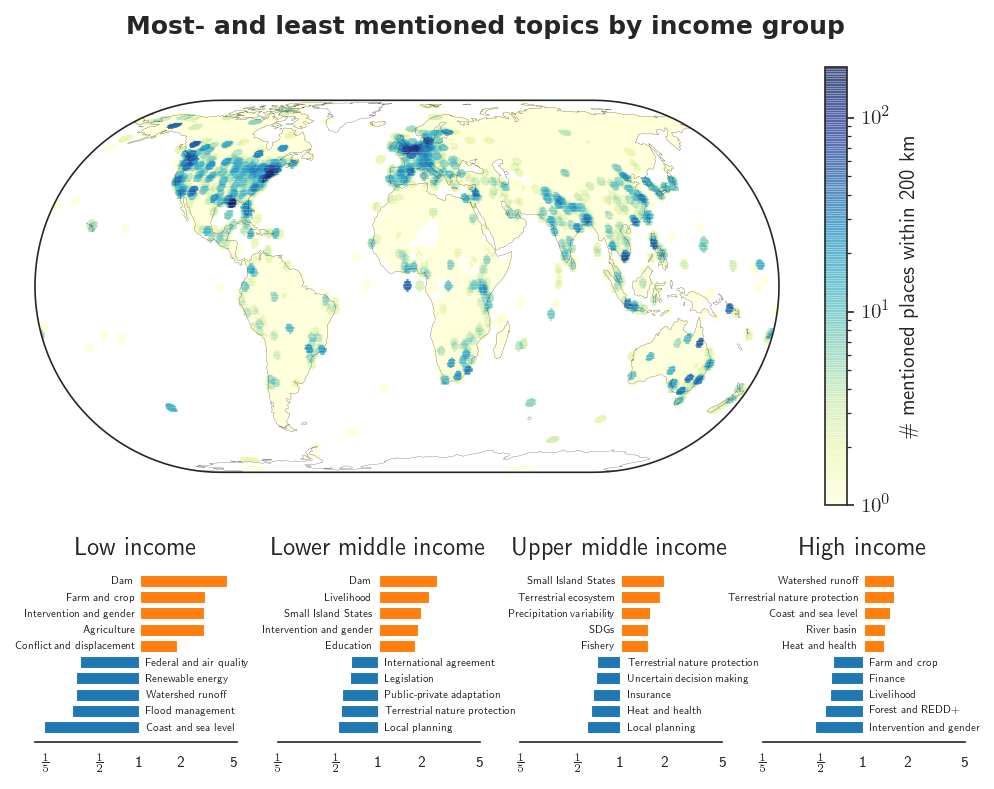

In [15]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rc
import geopandas
rc('text', usetex=True)

fig = plt.figure(dpi=150,figsize=(8,5))
gs = gridspec.GridSpec(2, len(income), height_ratios=[1, .4,], bottom=.05, top=.95, wspace=.2)
ax1 = plt.subplot(gs[0, :], projection=ccrs.EckertIV())
ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)


cbar = fig.colorbar(pcm)
cbar.set_label("\# mentioned places within 200 km")

pad = 0.1

xlab_positions = [.2,.5,1,2,5]
xlabels = [r"$\frac{1}{5}$",r"$\frac{1}{2}$",1,2,5]

ax_order = [3,0,1,2,4]


for i, cr in enumerate(income):
    ax = plt.subplot(gs[1,ax_order[i]])
    l = len(cr["common_topics_scores"])
    ax.set_title(cr["name"])
    ax.barh(range(l),np.log(cr["uncommon_topics_scores"]))
    ax.barh(range(l,l*2),np.log(cr["common_topics_scores"]))
    for j, lab in enumerate(cr["uncommon_topics"]):
        ax.text(0+pad,j,lab,ha="left", va="center", fontsize=5, usetex=True)
    for j, lab in enumerate(cr["common_topics"]):
        ax.text(0-pad,j+l, lab, ha="right", va="center", fontsize=5, usetex=True)
    sns.despine(ax=ax,top=True,left=True)
    ax.set_yticks([])
    ax.set_xticks([np.log(lab) for lab in xlab_positions])
    #ax.set_xticks(xlab_positions)
    ax.set_xticklabels(xlabels, fontsize=7, usetex=True)
    #ax.set_yticklabels(cr["uncommon_topics"] + cr["common_topics"],fontsize=6)


plt.suptitle("Most- and least mentioned topics by income group", 
             weight='bold', fontsize = 12,
             usetex=False,
            y=1.02)


fig.tight_layout()

In [16]:
country_conv.head()

,Country,Alpha-2,Alpha-3,Numeric code,Latitude (average),Longitude (average),UN continental,UN statistical,Population_2018,Population_2019,Annex I or II,SIDS,DFID priority,World Bank Income,World Bank Region,Income group
0,Afghanistan,AF,AFG,4,33.0000,65.0,Asia,Southern Asia,"37,171,921","38,041,754",Non-Annex I,,1,Low,South Asia,Low income
1,Albania,AL,ALB,8,41.0000,20.0,Europe,Southern Europe,"2,882,740","2,880,917",Non-Annex I,NaN,0,Upper-middle,Europe & Central Asia,Upper middle income
2,Algeria,DZ,DZA,12,28.0000,3.0,Africa,Northern Africa,"42,228,408","43,053,054",Non-Annex I,NaN,0,Upper-middle,Middle East & North Africa,Lower middle income
3,American Samoa,AS,ASM,16,-14.3333,-170.0,Oceania,Polynesia,"55,465","55,312",Non-Annex I,Pacific,0,Upper-middle,East Asia & Pacific,Upper middle income
4,Andorra,AD,AND,20,42.5000,1.6,Europe,Southern Europe,"77,006","77,142",Non-Annex I,NaN,0,High,Europe & Central Asia,High income


In [17]:
un_stat = []
nlabs = 5

for name, group in df.groupby('UN statistical'):
    un_stat.append(get_group_topics(name, group, dts))
    
len(un_stat)

23

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


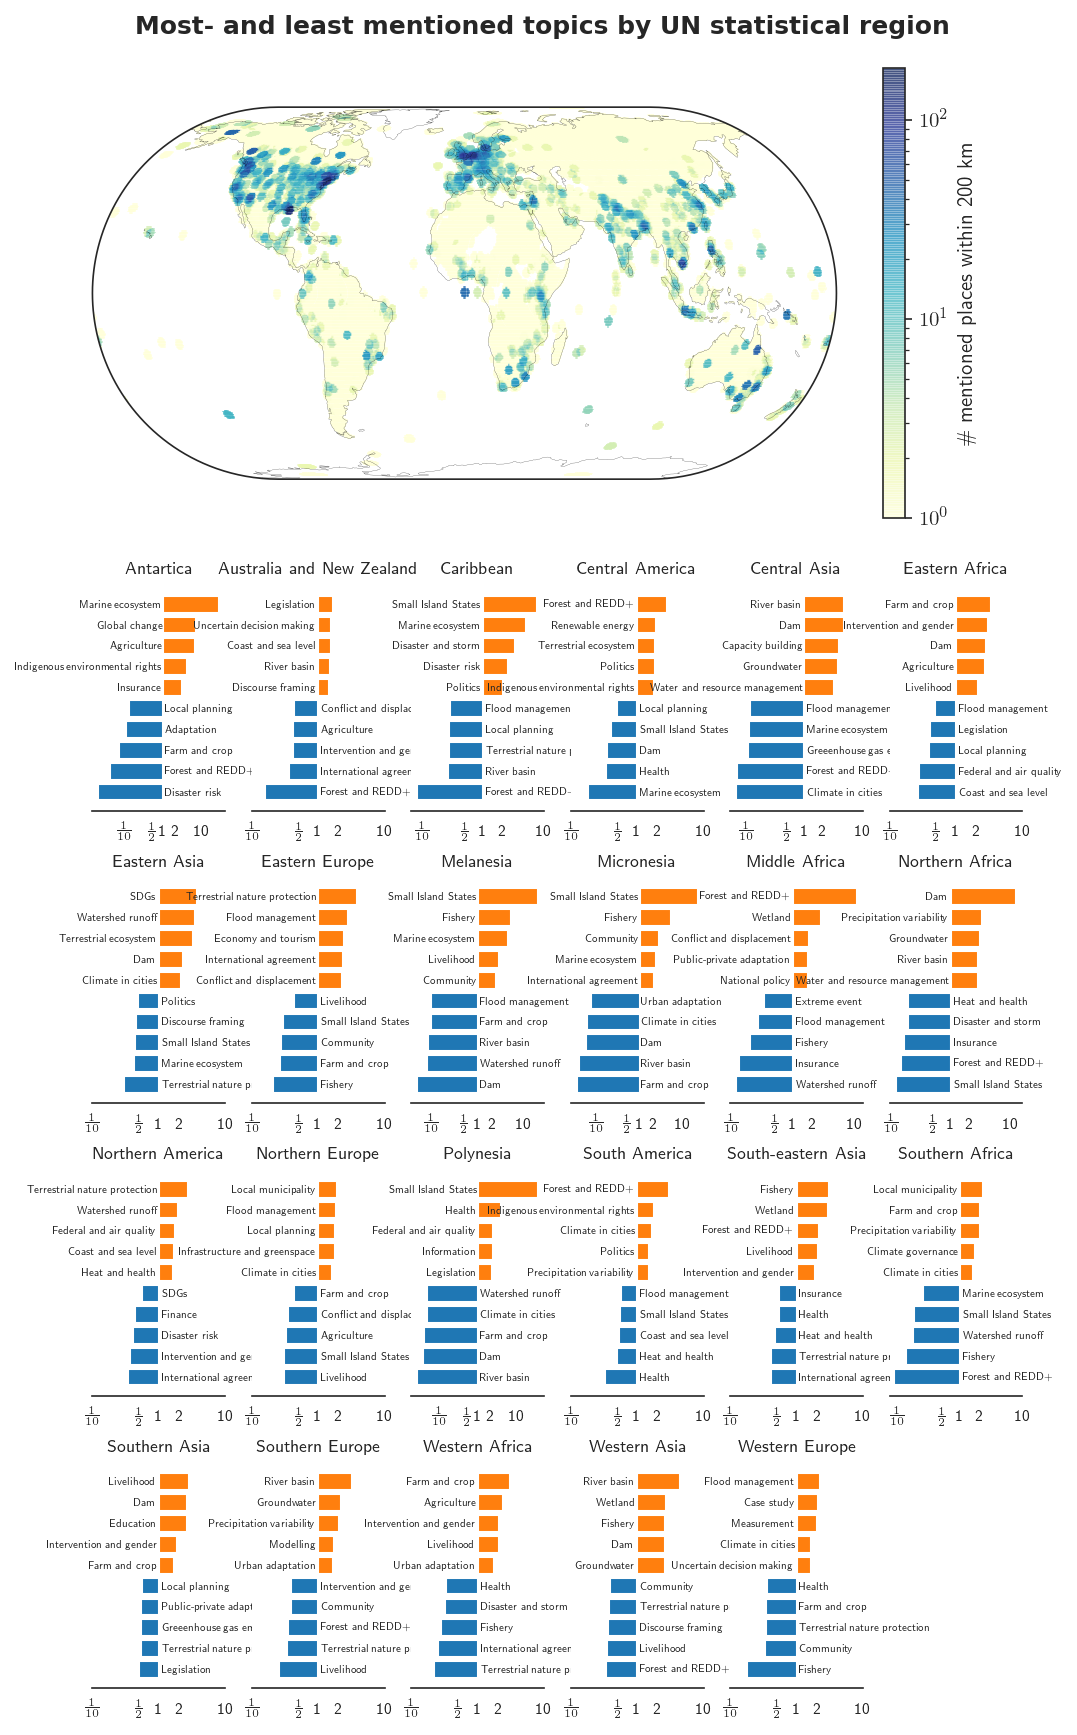

In [18]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rc
import geopandas
rc('text', usetex=True)

fig = plt.figure(dpi=150,figsize=(8,12))
gs = gridspec.GridSpec(5, 6, height_ratios=[.6, .3, .3, .3, .3], bottom=.05, top=.95, wspace=.2, hspace=.25)
ax1 = plt.subplot(gs[0, :], projection=ccrs.EckertIV())
ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)


cbar = fig.colorbar(pcm)
cbar.set_label("\# mentioned places within 200 km")

pad = 0.1

xlab_positions = [.1,.5,1,2,10]
xlabels = [r"$\frac{1}{10}$",r"$\frac{1}{2}$",1,2,10]


for i, cr in enumerate(un_stat):
    
    ax = plt.subplot(gs[1+i//6,i%6])
    l = len(cr["common_topics_scores"])
    ax.set_title(cr["name"],fontsize=8)
    ax.barh(range(l),np.log(cr["uncommon_topics_scores"]))
    ax.barh(range(l,l*2),np.log(cr["common_topics_scores"]))
    for j, lab in enumerate(cr["uncommon_topics"]):
        ax.text(0+pad,j,lab,ha="left", va="center", fontsize=5, usetex=True)
    for j, lab in enumerate(cr["common_topics"]):
        ax.text(0-pad,j+l, lab, ha="right", va="center", fontsize=5, usetex=True)
    sns.despine(ax=ax,top=True,left=True)
    ax.set_yticks([])
    ax.set_xticks([np.log(lab) for lab in xlab_positions])
    #ax.set_xticks(xlab_positions)
    ax.set_xticklabels(xlabels, fontsize=7, usetex=True)
    #ax.set_yticklabels(cr["uncommon_topics"] + cr["common_topics"],fontsize=6)


continent_df = pd.DataFrame

plt.suptitle("Most- and least mentioned topics by UN statistical region", 
             weight='bold', fontsize = 12,
             usetex=False,
            y=0.98)

fig.tight_layout()

## Now try the same but with the STM estimate effect results & error ranges

In [19]:
dtee = pd.read_csv('data/Region.csv', encoding='UTF-8')
print(dtee.shape)

#Remove the geographical topics
GeoTopics = [2, 21, 29, 34, 62, 71, 104]
dtee = dtee[~dtee['topic'].isin(GeoTopics)]
print(dtee.shape)

dtee.head(7)

(840, 5)
(784, 5)


,value,proportion,topic,lower,upper
0,South America,0.010980,1,0.008607,0.013526
1,Europe,0.011010,1,0.009368,0.012821
2,NaN,0.012143,1,0.011580,0.012726
3,North America,0.008282,1,0.006830,0.009704
4,Asia,0.014027,1,0.012516,0.015552
5,Africa,0.013553,1,0.011569,0.015604
6,Oceania,0.009867,1,0.007644,0.012084


In [20]:
#Add names
dtee = pd.merge(dtee, topic_info, how='left', left_on = 'topic', right_on = 'Topic NR')

dtee.head()

,value,proportion,topic,lower,upper,Topic NR,title,Short,Notes,Top keywords,id
0,South America,0.010980,1,0.008607,0.013526,1,Sustainable development,Sustainable,NaN,"Highest Prob: develop, sustain, climat_develo...",V1
1,Europe,0.011010,1,0.009368,0.012821,1,Sustainable development,Sustainable,NaN,"Highest Prob: develop, sustain, climat_develo...",V1
2,NaN,0.012143,1,0.011580,0.012726,1,Sustainable development,Sustainable,NaN,"Highest Prob: develop, sustain, climat_develo...",V1
3,North America,0.008282,1,0.006830,0.009704,1,Sustainable development,Sustainable,NaN,"Highest Prob: develop, sustain, climat_develo...",V1
4,Asia,0.014027,1,0.012516,0.015552,1,Sustainable development,Sustainable,NaN,"Highest Prob: develop, sustain, climat_develo...",V1


In [21]:
def printSelected(title, location):
    dt = dtee[(dtee['title'] == title) & (dtee['value'] == location)]
    dt = dt[['proportion', 'lower','upper',]]
    dt = dt*10500
    dt = dt-100
    print(dt)
printSelected('Agriculture', 'Africa')

     proportion      lower       upper
261   95.706463  49.403034  144.587684


In [22]:
continent_repS = []


def get_group_topics_STM(name, df, nlabs=6, normalise='percentage'):
    if normalise=='percentage':
        for col in ['proportion', 'lower','upper']:
            df[col] = df[col]*100*105
            
    cdf = df[df['value'] == name].sort_values('proportion', ascending=True).head(nlabs)  #common
    udf = df[df['value'] == name].sort_values('proportion', ascending=True).tail(nlabs)  #uncommon
    
    
    #We will need the error output in left-right rather than upper-lower
    common=[]
    uncommon=[]
    for i, r in cdf.iterrows():
        common.append([abs(r['proportion'] - r['lower']) , abs(r['proportion'] - r['upper'])])
    for i, r in udf.iterrows():
        uncommon.append([abs(r['proportion'] - r['lower']) , abs(r['proportion'] - r['upper'])])
    common = np.array([*common]).T
    uncommon = np.array([*uncommon]).T
    
    return {
        "name": name,
        "common_topics": cdf['title'],
        "common_topics_scores": cdf['proportion'],
        "common_uncertainties": common,
        "uncommon_topics": udf['title'],
        "uncommon_topics_scores": udf['proportion'],
        "uncommon_uncertainties": uncommon      
    }


for name in dtee['value'].dropna().unique():
    if name != 'Antartica': #Don't have enough studies here for it to be meaningful
        continent_repS.append(get_group_topics_STM(name, dtee, normalise=False))
    #gdt = get_group_topics(name, group, dts)
continent_repS[0]

{'common_topics': 640             Local planning
 464                      Level
 680    Intervention and gender
 512    Federal and air quality
 536                  Education
 360            Heat and health
 Name: title, dtype: object, 'common_topics_scores': 640    0.003517
 464    0.003873
 680    0.004025
 512    0.004264
 536    0.004845
 360    0.004946
 Name: proportion, dtype: float64, 'common_uncertainties': array([[0.00324459, 0.00130741, 0.00308482, 0.00310499, 0.00364716,
         0.0057213 ],
        [0.00319506, 0.00136103, 0.0034091 , 0.00339151, 0.00380038,
         0.0060822 ]]), 'name': 'South America', 'uncommon_topics': 48                   Study
 304    Nature conservation
 376               Politics
 664                Climate
 200            Groundwater
 704       Forest and REDD+
 Name: title, dtype: object, 'uncommon_topics_scores': 48     0.014068
 304    0.017622
 376    0.019079
 664    0.024359
 200    0.026235
 704    0.031499
 Name: proportion, dtype: fl

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


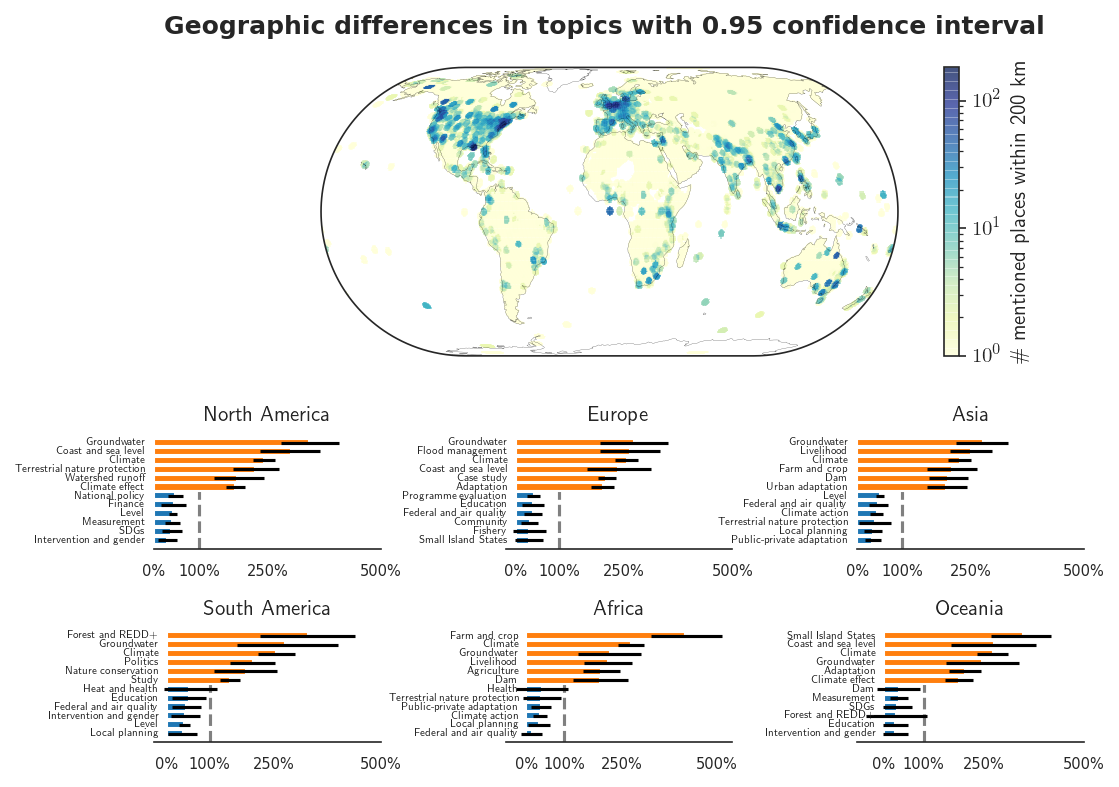

In [23]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)


fig = plt.figure(dpi=150,figsize=(8,5))

gs = gridspec.GridSpec(3, 3, #One row for map, two rows with 3 bars each
                       height_ratios=[1, .4, .4], 
                       bottom=.05, top=.95, wspace=.55, hspace=.45)

ax1 = plt.subplot(gs[0, :], projection = ccrs.EckertIV()) #Set projection here
ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform= ccrs.PlateCarree(), #Setting this to anything but PlateCarree seems to get an empty output
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

cbar = fig.colorbar(pcm)
cbar.set_label("\# mentioned places within 200 km")

pad = .002

xlab_positions = [0,100, 250, 500]
xlabels = [f"{lab}%" for lab in xlab_positions]
xlab_positions = [lab/10500 for lab in xlab_positions]


ax_order = [3, 1, 0, 2, 4, 5]

continents = { #mapping from the name used in the table to whatever you want to use as title
    'South America': 'South America', #these were not replaced above
    'North America': 'North America',
    'Asia': 'Asia',
    'Oceania': 'Oceania',
    'Africa': 'Africa',
    'Europe': 'Europe',
    #'Antartica': 'Antartica'
}


for i, cr in enumerate(continent_repS):
    order = ax_order[i]
    ax = plt.subplot(gs[1+order//3,order%3]) #First row or second row
    l = len(cr["common_topics_scores"])
    ax.set_title(continents[cr["name"]], size = 10)
    ax.barh(range(l),cr["common_topics_scores"], xerr = cr['common_uncertainties'], color='#1f77b4') #REMOVED LOG SCALE FOR ALL!
    ax.barh(range(l,l*2),cr["uncommon_topics_scores"], xerr = cr['uncommon_uncertainties'], color='#ff7f0e')
    for j, lab in enumerate(cr["common_topics"]):
        ax.text(0-pad,j,lab,ha="right", va="center", fontsize=5, usetex=True)
    for j, lab in enumerate(cr["uncommon_topics"]):
        ax.text(0-pad,j+l, lab, ha="right", va="center", fontsize=5, usetex=True)
    sns.despine(ax=ax,top=True,left=True)
    ax.axvline(1/105, ls ='--', zorder=-1, c='grey')
    ax.set_yticks([])
    ax.set_xticks([(lab) for lab in xlab_positions])
    #ax.set_xticks(xlab_positions)
    ax.set_xticklabels(xlabels, fontsize=7, usetex=False)
    #ax.set_yticklabels(cr["uncommon_topics"] + cr["common_topics"],fontsize=6)


continent_df = pd.DataFrame

fig.suptitle("Geographic differences in topics with 0.95 confidence interval",
            weight='bold', fontsize = 12,
             usetex = False,
            y=1.02)


fig.tight_layout()

#plt.savefig(r"Out/topics_continent.png", bbox_inches='tight')

### Comparing to Grantham

In [9]:
granDf = pd.read_csv("data/Grantham_laws_and_policies_06072022.csv")
print(granDf.columns)
granDf.head()

Index(['Id', 'Title', 'Type', 'Geography', 'Geography ISO', 'Frameworks',
       'Responses', 'Instruments', 'Document Types', 'Natural Hazards',
       'Keywords', 'Sectors', 'Events', 'Documents', 'Parent Legislation',
       'Description'],
      dtype='object')


,Id,Title,Type,Geography,Geography ISO,Frameworks,Responses,Instruments,Document Types,Natural Hazards,Keywords,Sectors,Events,Documents,Parent Legislation,Description
0,4621,Rural Renewable Energy Policy (RREP),executive,Afghanistan,AFG,NaN,Adaptation,"Standards, obligations and norms|Regulation;Su...",Policy,NaN,Adaptation;Energy Supply,Energy,25/12/2013|Law passed||,Full text (PDF)|https://climate-laws.org/rails...,NaN,"This policy aims at creating better social, ec..."
1,4622,National Forestry Management Policy (NFMP),executive,Afghanistan,AFG,NaN,Adaptation;Mitigation,"Research & Development, knowledge generation|I...",Policy,NaN,Research And Development,Economy-wide,25/12/2007|Law passed||,NaN,NaN,"This law was identified in Afghanistan's NDC, ..."
2,4624,Strategic National Action Plan for Disaster Ri...,executive,Afghanistan,AFG,DRM/DRR,Adaptation;Disaster Risk Management,"Processes, plans and strategies|Governance;MRV...",Plan,Earthquake;Flood;Snow melt;Glacial Melt;Drough...,Adaptation,NaN,25/12/2011|Law passed||,NaN,NaN,This Action Plan includes the objective of uti...
3,4625,The National Environmental Action Plan (NEAP),executive,Afghanistan,AFG,NaN,Adaptation,NaN,Plan,NaN,Adaptation,NaN,25/12/2009|Law passed||,NaN,NaN,"This law was identified in Afghanistan's NDC, ..."
4,4849,National Biodiversity Strategy and Action Plan,executive,Afghanistan,AFG,NaN,Adaptation,"Capacity building|Governance;Processes, plans ...",Strategy,NaN,Adaptation;Carbon Pricing,Environment;LULUCF,25/12/2014|Law passed,Full text|https://climate-laws.org/rails/activ...,NaN,This document notably examines the threats on ...


In [10]:
latbins, lonbins, n = density_grid(granDf, countryColumn = 'Geography ISO', places = False)

calculating density grid of size: 259200
Grid calculated
Countries added


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


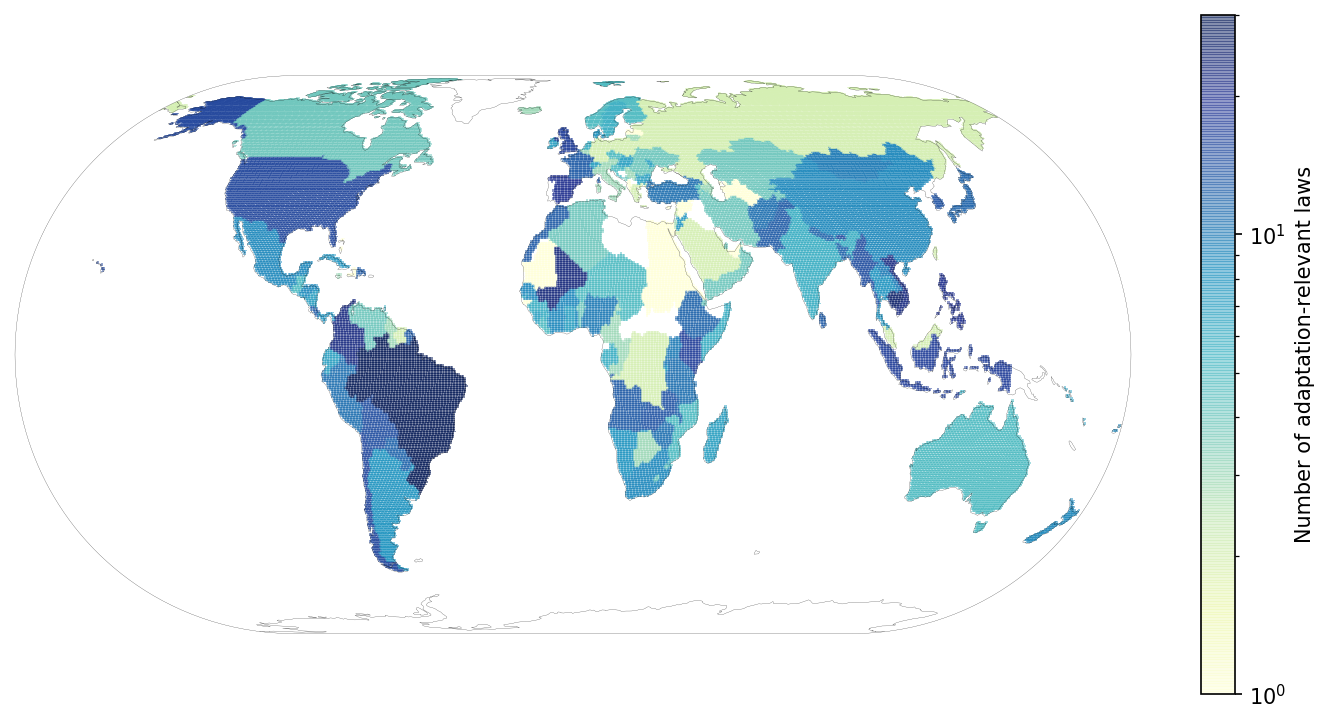

In [24]:
fig, ax = plt.subplots(dpi=150, figsize=(12,6))

#p = ccrs.Mollweide() #Choose projection
#p = ccrs.PlateCarree()
p = ccrs.EckertIV()

ax = plt.axes(projection=p)
ax.set_global()
ax.coastlines(lw=0.1)

vm = n[~np.isnan(n)].max()

n[n == 0] = np.nan

pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

ax.outline_patch.set_linewidth(0.1)

cbar = fig.colorbar(pcm)
cbar.set_label("Number of adaptation-relevant laws")

fig.tight_layout()

In [ ]:
wbr = [] #World bank region
nlabs = 5

#Rename as cannot deal with the ampersand
df.loc[df['World Bank Region'] == 'East Asia & Pacific', 'World Bank Region'] = 'East Asia and Pacific'
df.loc[df['World Bank Region'] == 'Europe & Central Asia', 'World Bank Region'] = 'Europe and Central Asia'
df.loc[df['World Bank Region'] == 'Latin America & Caribbean', 'World Bank Region'] = 'Latin America and Caribbean'
df.loc[df['World Bank Region'] == 'Middle East & North Africa', 'World Bank Region'] = 'Middle East and North Africa'

for name, group in df.groupby('World Bank Region'):
    wbr.append(get_group_topics(name, group, dts))
len(wbr)

In [ ]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rc
import geopandas
rc('text', usetex=True)


fig = plt.figure(dpi=150,figsize=(8,5))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, .5, .5], bottom=.2, top=1.15, wspace=.2, hspace=.35)
ax1 = plt.subplot(gs[0, :], projection=ccrs.Mollweide())
ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

fig.set_facecolor('w') 


# Outline DFID priority countries
# poly = country_shapes.loc[country_shapes['DFID priority'] == 1]['geometry'].values

# ax1.add_geometries(
#     poly, 
#     crs=ccrs.PlateCarree(), 
#     facecolor='none', 
#     edgecolor='black',
#     lw=0.2
# )



cbar = fig.colorbar(pcm)
cbar.set_label("\# mentioned places within 100 km")

pad = 0.1

xlab_positions = [.1,.5,1,2,10]
xlabels = [r"$\frac{1}{10}$",r"$\frac{1}{2}$",1,2,10]

ax_order = [3,0,1,2,4,5,6]


for i, cr in enumerate(wbr):
    ax = plt.subplot(gs[1+i//4,i%4])
    l = len(cr["common_topics_scores"])
    ax.set_title(cr["name"], fontsize=8)
    ax.barh(range(l),np.log(cr["uncommon_topics_scores"]))
    ax.barh(range(l,l*2),np.log(cr["common_topics_scores"]))
    for j, lab in enumerate(cr["uncommon_topics"]):
        ax.text(0+pad,j,lab,ha="left", va="center", fontsize=5, usetex=True)
    for j, lab in enumerate(cr["common_topics"]):
        ax.text(0-pad,j+l, lab, ha="right", va="center", fontsize=5, usetex=True)
    sns.despine(ax=ax,top=True,left=True)
    ax.set_yticks([])
    ax.set_xticks([np.log(lab) for lab in xlab_positions])
    #ax.set_xticks(xlab_positions)
    ax.set_xticklabels(xlabels, fontsize=7, usetex=True)
    #ax.set_yticklabels(cr["uncommon_topics"] + cr["common_topics"],fontsize=6)


continent_df = pd.DataFrame


fig.tight_layout()

In [ ]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rc
import geopandas
rc('text', usetex=True)



def new_haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1[:,None]

    dlat = lat2 - lat1[:,None]

    a = np.sin(dlat/2.0)**2 + np.cos(lat1[:,None]) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def density_grid(degrees,distance,df, extent=None, include_countries=None):
    
    df_countries = df[df["feature_code"]=="PCLI"]
    df_places = df[df["feature_code"]!="PCLI"]


    latbins = np.linspace(-90,90, round(180/degrees))   
    lonbins = np.linspace(-180,180, round(360/degrees))
    
    if extent is not None:      
        lonbins = lonbins[(lonbins>=extent[0]) & (lonbins<=extent[1])]
        latbins = latbins[(latbins>=latbins[2]) & (latbins<=extent[3])]

    n = np.zeros((len(latbins),len(lonbins)))
    
    print(f"calculating density grid of size: {n.size}")

    for i,lat in enumerate(latbins):
        r = geopy.distance.distance(kilometers=distance)
        latp = geopy.Point((lat,135))
        # if the latitude is closer than distance to the north pole, then the northern bound should be 
        # the north pole, not distancekm north of the latitude (which will pass the pole and go south again)
        if geopy.distance.great_circle(latp,(90,135)).km < distance:
            r_nbound = 90   
        else:
            r_nbound = r.destination(point=latp,bearing=0).latitude
        # Same as above for the south pole
        if geopy.distance.great_circle(latp,(-90,135)).km < distance:
            r_sbound = -90   
        else:
            r_sbound = r.destination(point=latp,bearing=180).latitude        

        latbound_df = df_places[
            (df_places.lat>=r_sbound) &
            (df_places.lat<=r_nbound)        
        ]

        ds = new_haversine_np(latbound_df['lon'], latbound_df['lat'],lonbins,[lat]*len(lonbins))

        n[i,:] = np.where(ds<distance,1,0).sum(axis=0)
        
    print("done")
    
    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    yv, xv = np.meshgrid(latbins, lonbins)

    for country in reader.records():
        incountry = shapely.vectorized.contains(country.geometry,xv,yv)
        idx = np.argwhere(incountry==True)
        ndots = idx.size/2
        cdf = df_countries[df_countries["country_predicted"]==country.attributes["SU_A3"]]
        for point in idx:
            n[point[1],point[0]] += cdf.shape[0]/ndots


        
    return latbins, lonbins, n

extent = [60,102,0,43]

latbins, lonbins, n = density_grid(0.2,50,df_places, extent = extent)


fig = plt.figure(dpi=150,figsize=(8,12))
gs = gridspec.GridSpec(5, 6, height_ratios=[.6, .3, .3, .3, .3], bottom=.05, top=.95, wspace=.2, hspace=.25)
#ax1 = plt.subplot(gs[0, :], projection=ccrs.Mollweide())
ax1 = plt.subplot(gs[0, :], projection=ccrs.PlateCarree())
ax1.set_extent(extent)
#ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

# read the german borders
poly = country_shapes.loc[country_shapes['DFID priority'] == 1]['geometry'].values

ax1.add_geometries(
    poly, 
    crs=ccrs.PlateCarree(), 
    facecolor='none', 
    edgecolor='black',
    lw=0.5
)


In [ ]:
country_shapes.head()

In [ ]:

latbins, lonbins, n = density_grid(1,100,df_places)

fig, ax = plt.subplots(dpi=150, figsize=(8,5))
p = ccrs.Mollweide()
#p = ccrs.PlateCarree()

ax = plt.axes(projection=p)
ax.set_global()
ax.coastlines(lw=0.1)

vm = n[~np.isnan(n)].max()

n[n == 0] = np.nan

pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

i = 0
for name, group in country_shapes.groupby("UN statistical"):
    if group["DFID priority"].sum() > 0:
        i+=1
        poly = group.loc[
            (group['DFID priority'] == 1) 
        ]['geometry'].values

        ax.add_geometries(
            poly, 
            crs=ccrs.PlateCarree(), 
            facecolor='none', 
            edgecolor=f'C{i}',
            lw=0.5
        )

        print(name)

cbar = fig.colorbar(pcm)
cbar.set_label("\# mentioned places within 100 km")

In [ ]:
df_places.head()

In [ ]:
fig = plt.figure(dpi=150,figsize=(8,12))

region_groups = [
    #["Eastern Africa", "Northern Africa","Middle Africa"],
    ["Central Asia"]
]

extents = [
    #[5,55,-30,30],
    [65,80,35,45]
]

fig = plt.figure(dpi=150,figsize=(8,12))

cols = 5
nrows = len(extents)//cols+1

gs = gridspec.GridSpec(nrows*2, cols, height_ratios=[.6, .3]*nrows, bottom=.05, top=.95, wspace=.2, hspace=.25)



for i, (regions, extent) in enumerate(zip(region_groups, extents)):
    
    ax1 = plt.subplot(gs[0, 0], projection=ccrs.Mollweide())

    cs = country_shapes.loc[
        (country_shapes['DFID priority'] == 1) & 
        (country_shapes['UN statistical'].isin(regions))
    ]

    sub_df = df_places[df_places["country_predicted"].isin(cs["SOV_A3"])]

    latbins, lonbins, n = density_grid(1,50,sub_df, extent = extent)

    ax1.set_extent(extent)
    ax1.coastlines(lw=0.1)
    ax1.add_feature(cartopy.feature.BORDERS,lw=0.1)
    ax1.add_feature(cartopy.feature.OCEAN)

    pcm = plt.pcolormesh( 
        lonbins, latbins, n,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
        alpha=0.5,
        cmap="YlGnBu"
    )

    poly = country_shapes.loc[
        (country_shapes['DFID priority'] == 1) & 
        (country_shapes['UN statistical'].isin(regions))
    ]['geometry'].values

    ax1.add_geometries(
        poly, 
        crs=ccrs.PlateCarree(), 
        facecolor='none', 
        edgecolor='black',
        lw=0.5
    )

In [ ]:
dfid_countries = country_shapes.loc[
    (country_shapes['DFID priority'] == 1) 
]
dfid_df = df_places[df_places["country_predicted"].isin(dfid_countries["SOV_A3"])]

latbins, lonbins, n = density_grid(0.5,50,dfid_df, extent = extent)
vm = n[~np.isnan(n)].max()
dfid_df.head()

In [ ]:
print(sub_df.shape)

In [ ]:
country_shapes.to_csv('../dash-dfid/data/country_shapes.csv',index=False)

In [ ]:
## fig = plt.figure(dpi=150,figsize=(8,12))

region_groups = [
    ["Western Africa"],
    ["Eastern Africa", "Northern Africa","Middle Africa"],
    ["Western Asia"],
    ["Central Asia"],
    ["Southern Asia"],
    ["South-eastern Asia"]

]

labels = [
    "Western Africa",
    "Middle, Eastern and \nNorthern Africa",
    "Western Asia",
    "Central Asia",
    "Southern Asia",
    "South-eastern Asia"
]

extents = [
    [-15,5,0,20],
    [5,55,-30,30],
    [30,60,10,40],
    [66,81,35,45],
    [59,99,3,43],
    [90,145,-20,30]
]

fig = plt.figure(dpi=150,figsize=(8,8))

cols = 2
nrows = len(extents)//cols+1

#gs = gridspec.GridSpec(nrows*2, cols, height_ratios=[.3, .3]*nrows, bottom=.05, top=.95, wspace=.2, hspace=.25)
gs = gridspec.GridSpec(nrows, cols*2, height_ratios=[1]*(nrows-1)+[.25],bottom=.05, top=.95, wspace=.2, hspace=.25)

xlab_positions = [1,2,4,8]
xlabels = [1,2,4,8]


for i, (regions, extent,label) in enumerate(zip(region_groups, extents,labels)):
    
    
    #ax1 = plt.subplot(gs[0, i], projection=ccrs.Mollweide())
    r = i//cols
    c = i%cols*2
    
    ax1 = plt.subplot(gs[r, c], projection=ccrs.PlateCarree())
    cs = country_shapes.loc[
        (country_shapes['DFID priority'] == 1) & 
        (country_shapes['UN statistical'].isin(regions))
    ]

    sub_df = df_places[df_places["country_predicted"].isin(cs["SOV_A3"])]

    latbins, lonbins, n = density_grid(0.5,100,sub_df, extent = extent)

    ax1.set_extent(extent)
    ax1.coastlines(lw=0.1)
    ax1.add_feature(cartopy.feature.BORDERS,lw=0.1)
    ax1.add_feature(cartopy.feature.OCEAN)

    pcm = plt.pcolormesh( 
        lonbins, latbins, n,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
        alpha=0.5,
        cmap="YlGnBu"
    )

    poly = country_shapes.loc[
        (country_shapes['DFID priority'] == 1) & 
        (country_shapes['UN statistical'].isin(regions))
    ]['geometry'].values

    ax1.add_geometries(
        poly, 
        crs=ccrs.PlateCarree(), 
        facecolor='none', 
        edgecolor='black',
        lw=0.5
    )
    
    cr = get_group_topics(label,sub_df,dts,8)
    
    ax = plt.subplot(gs[r,c+1])
    l = len(cr["common_topics_scores"])
    
    
    
    ax1.set_title(f'{cr["name"]}, {len(sub_df.id.unique())} studies',fontsize=8)
    #ax.barh(range(l),np.log(cr["uncommon_topics_scores"]))
    ax.barh(
        range(l),np.log(cr["common_topics_scores"]),color="None",
        edgecolor="C1"
    )
    #for j, lab in enumerate(cr["uncommon_topics"]):
        #ax.text(0+pad,j,lab,ha="left", va="center", fontsize=5, usetex=True)
    for j, lab in enumerate(cr["common_topics"]):
        ax.text(0+pad,j, lab, ha="left", va="center", fontsize=5, usetex=True)
    sns.despine(ax=ax,top=True,left=True)
    ax.set_yticks([])
    ax.set_xticks([np.log(lab) for lab in xlab_positions])
    #ax.set_xticks(xlab_positions)
    ax.set_xticklabels(xlabels, fontsize=7, usetex=True)
    ax.set_xlabel("Region topic share/average topic share",fontsize=6)
    
ax = plt.subplot(gs[nrows-1,:])
ax.axis("off")
cbar = fig.colorbar(pcm,ax=ax,orientation="horizontal",fraction=0.5,pad=-1)
cbar.ax.tick_params(labelsize=7)

cbar.set_label("\# mentioned places within 100 km")

In [ ]:
for regions, label in zip(region_groups,labels):
    dfid_df.loc[dfid_df["UN statistical"].isin(regions),"DFID region"] = label
    
dfid_df['place_doc_id'] = dfid_df.index
    
dfid_df.drop(columns="content").to_csv('../dash-dfid/data/dfid_df.csv',index=False)
    
gdt = (dfid_df[["doc_id","DFID region"]]
       .merge(dts)
       .groupby(['topic_id','DFID region'])['score']
       .sum()
       .reset_index()
      )
gdt['share'] = gdt['score'] / gdt.groupby('DFID region')['score'].transform('sum')
gdt = gdt.merge(dt_sum)
gdt['deviation'] = gdt['share'] / gdt['total_share']
gdt = (gdt
       .merge(topic_info, left_on="topic_id",right_on="id")
       .sort_values(['DFID region','deviation'])
       .reset_index(drop=True)
      )
gdt['short_title'] = gdt['title'].str.split(',').str[0]
gdt.to_csv('../dash-dfid/data/dfid_topics.csv', index=False)
gdt.head()

In [ ]:
dts[dts['doc_id'].isin(dfid_df['doc_id'])].to_csv('../dash-dfid/data/doctopic.csv',index=False)

In [ ]:
gdt[gdt['DFID region']=="Western Africa"]

In [ ]:
dfid_df.head()

In [ ]:
dfid_df.place_doc_id = dfid_df.index
dfid_df

In [ ]:
dfid_countries

In [ ]:
country

In [ ]:
country_shapes.columns

In [ ]:
geojson = country_shapes[["geometry","SOV_A3","DFID priority"]].rename(columns={"SOV_A3": "id"})
geojson[geojson['DFID priority']==1].to_file('../dash-dfid/data/dfid.geojson', driver='GeoJSON')

In [ ]:
country_shapes[["SOV_A3","DFID priority",'UN statistical']].to_csv('../dash-dfid/data/country_shapes.csv', index=False)

In [ ]:
df_places.to_csv('data/df_places.csv',index=False)